Visualizing Missingness

Overall missingness in features: 99.05%
Number of features with any missingness: 9961 out of 9961


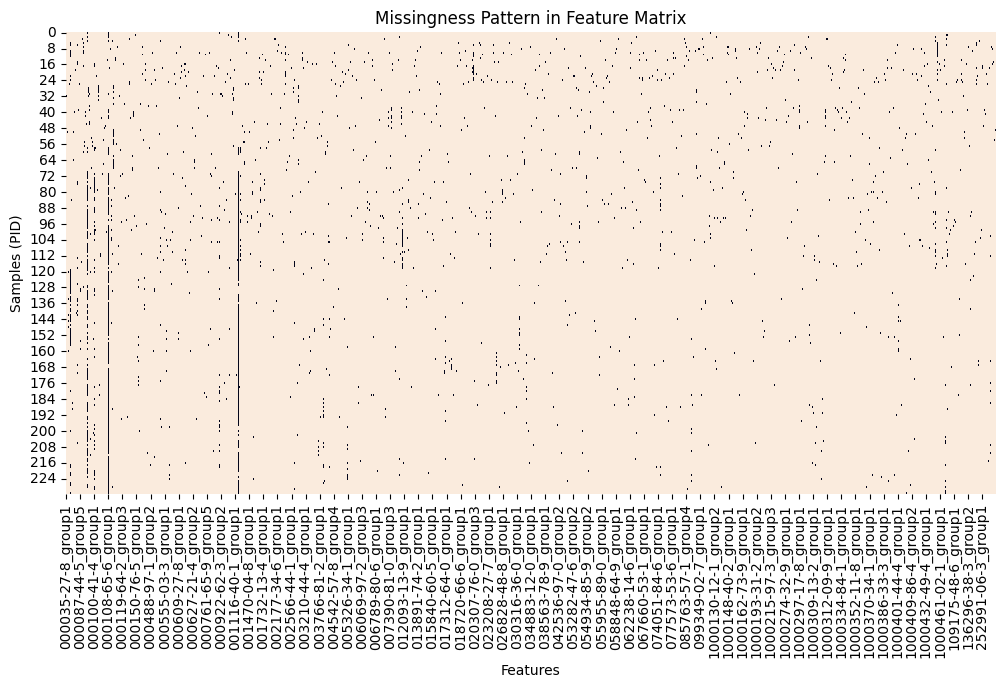

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data
df_main2_cleaned = pd.read_csv('df_main2_cleaned.csv')

# Excluding demos
feature_cols = [col for col in df_main2_cleaned.columns if col not in ['PID', 'TB Status', 'Age', 'BMI', 'HIV Status']]
# dtype issue correction. It will still throw a warning, but the line below resolves this
df_main2_cleaned[feature_cols] = df_main2_cleaned[feature_cols].apply(pd.to_numeric, errors='coerce')


# How much is missing
missing_perc = df_main2_cleaned[feature_cols].isnull().mean().mean() * 100
print(f"Overall missingness in features: {missing_perc:.2f}%")

# How many features are missing
features_with_missing = df_main2_cleaned[feature_cols].isnull().any().sum()
print(f"Number of features with any missingness: {features_with_missing} out of {len(feature_cols)}")

plt.figure(figsize=(12, 6))
sns.heatmap(df_main2_cleaned[feature_cols].isnull(), cbar=False)
plt.title('Missingness Pattern in Feature Matrix')
plt.xlabel('Features')
plt.ylabel('Samples (PID)')
plt.show()

In [5]:
# Filter to keep only features present >=10% of samples
min_present = len(df_main2_cleaned) * 0.10
filtered_features = [col for col in feature_cols if df_main2_cleaned[col].notnull().sum() >= min_present]
print(f"Features retained after filtering: {len(filtered_features)}")
df_main2_clean_filter = df_main2_cleaned[filtered_features]

# List of CAS numbers to exclude
excluded_cas = [
    '000074-97-5_group1',  # IS for R2D2
]

# Drop these columns if they exist
df_main2_clean_filter = df_main2_clean_filter.drop(columns=[col for col in excluded_cas if col in df_main2_clean_filter.columns])
print(f"Features remaining after manual exclusion {len(df_main2_clean_filter.columns)}")

Features retained after filtering: 79
Features remaining after manual exclusion 78


This is a huge drop in features, but not suprising. Dropping from 10,400 to 79 seems reasonable as this is exhalled VOCs.

**NOTE:** Unable to use BaylorEdPsych package for Little's MCAR does not work with current versions of R and is a noted grevience in the community. The same goes for running QRILC with the imputeLCMD package. Packages for R 4.4 have not been udpated which is why they are not working. 

Using R 3.6.3 in a Docker to use imputeLCMD package. RF was attempted using the MissForest algorithm (Stekhoven & Bühlmann, 2012) implemented in R (v4.4.0) via the missForest package, but was decided inapropriate given the missingness nature of this GCMS data being NCAR.

Went back after finishing entire workup to look into identified key features. One was the IS for the R2D2 group. Removing this manually.

In [6]:
# Exporting df for use in Docker image
df_main2_clean_filter.to_csv("df_to_impute.csv", index=False)  # <- place this in same folder as the Docker

**NOTE** This is where the R Docker script should be run

* run 'make' in terminal after navigating to folder
* run 'docker run -it --rm -v "$(PWD)":/home/ruser/data impute_lcmd_r Rscript /home/ruser/data/imputation_script.R'' after container is built

In [7]:
# Importing df from R post imputation with imputeLCMD package
imputed = pd.read_csv("imputed_output.csv")  # <- will need to copy this from the Docker folder to the Jupyter Area

# R named the CAS-RT Groups differently. Replacing original style:
imputed.columns = df_main2_clean_filter.columns

# pulling PID and demographic columns back in from df_main2_cleaned
df_main3 = pd.concat([
    df_main2_cleaned[['PID', 'TB Status', 'Age', 'BMI', 'HIV Status']].reset_index(drop=True),
    imputed
], axis=1)

**NOTE TO SELF** we skipped TIC because they already should have been TIC'd before. 

Running df_main3.describe() confirms this

In [8]:
df_main3.describe()  # QC step to confirm TIC already occured

,Age,BMI,000067-64-1_group2,000067-68-5_group1,000074-95-3_group1,000077-68-9_group1,000078-79-5_group2,000078-93-3_group1,000091-20-3_group1,000095-16-9_group2,...,038165-93-4_group1,054446-78-5_group1,063521-76-6_group3,095798-15-5_group1,1000132-10-9_group2,1000308-17-8_group1,1000309-13-0_group1,1000386-40-2_group1,1000401-12-0_group1,1000417-00-6_group1
count,232.00000,230.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,...,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,36.25000,21.131345,0.221253,-0.123114,-0.027392,0.073275,-0.194618,-0.089045,0.272388,-0.035694,...,0.041919,-0.163201,-0.166964,-0.367979,-0.012793,-0.122311,-0.302102,-0.351863,-0.081829,-0.105950
std,11.30902,4.394879,0.314689,0.157379,0.067158,0.156001,0.428386,0.132994,0.166698,0.090887,...,0.710440,0.232301,0.172202,0.740767,0.054106,0.120813,0.378372,0.307325,0.127024,0.118238
min,18.00000,13.714286,-0.463342,-0.426678,-0.180845,-0.230935,-0.801522,-0.371630,-0.095700,-0.266410,...,-0.908194,-0.630265,-0.486309,-0.984971,-0.157558,-0.409729,-0.862049,-0.798790,-0.437585,-0.387903
25%,27.00000,17.993080,0.003546,-0.243463,-0.077198,-0.036034,-0.502946,-0.177211,0.144245,-0.091713,...,-0.485881,-0.334373,-0.284513,-0.831778,-0.052221,-0.206657,-0.594680,-0.571092,-0.165849,-0.180555
50%,35.00000,20.618645,0.176632,-0.142583,-0.028622,0.055227,-0.338305,-0.095856,0.277350,-0.037911,...,-0.196055,-0.179537,-0.194352,-0.596556,-0.012025,-0.129563,-0.369127,-0.419119,-0.093564,-0.111565
75%,45.00000,23.363298,0.452700,-0.028175,0.017257,0.157800,0.014047,-0.017067,0.380625,0.015768,...,0.360369,-0.031304,-0.057341,-0.251647,0.027590,-0.046792,-0.158600,-0.190858,0.006585,-0.036066
max,72.00000,38.514057,1.049000,0.351500,0.154200,0.792200,1.838300,0.637400,0.789400,0.247500,...,2.821900,0.790700,0.355700,3.918500,0.123300,0.262400,1.393500,0.907900,0.267300,0.213800


**Z-Scoring data**

Z-scored feature means (should be ~0):000067-64-1_group2    -1.914178e-17
000067-68-5_group1     1.531342e-17
000074-95-3_group1    -4.594026e-17
000077-68-9_group1    -4.594026e-17
000078-79-5_group2    -7.656711e-18
                           ...     
1000308-17-8_group1    3.062684e-17
1000309-13-0_group1   -1.684476e-16
1000386-40-2_group1    1.225074e-16
1000401-12-0_group1   -1.225074e-16
1000417-00-6_group1   -3.828355e-17
Length: 78, dtype: float64 

Z-scored feature std devs (should be ~1): 000067-64-1_group2     1.002162
000067-68-5_group1     1.002162
000074-95-3_group1     1.002162
000077-68-9_group1     1.002162
000078-79-5_group2     1.002162
                         ...   
1000308-17-8_group1    1.002162
1000309-13-0_group1    1.002162
1000386-40-2_group1    1.002162
1000401-12-0_group1    1.002162
1000417-00-6_group1    1.002162
Length: 78, dtype: float64 



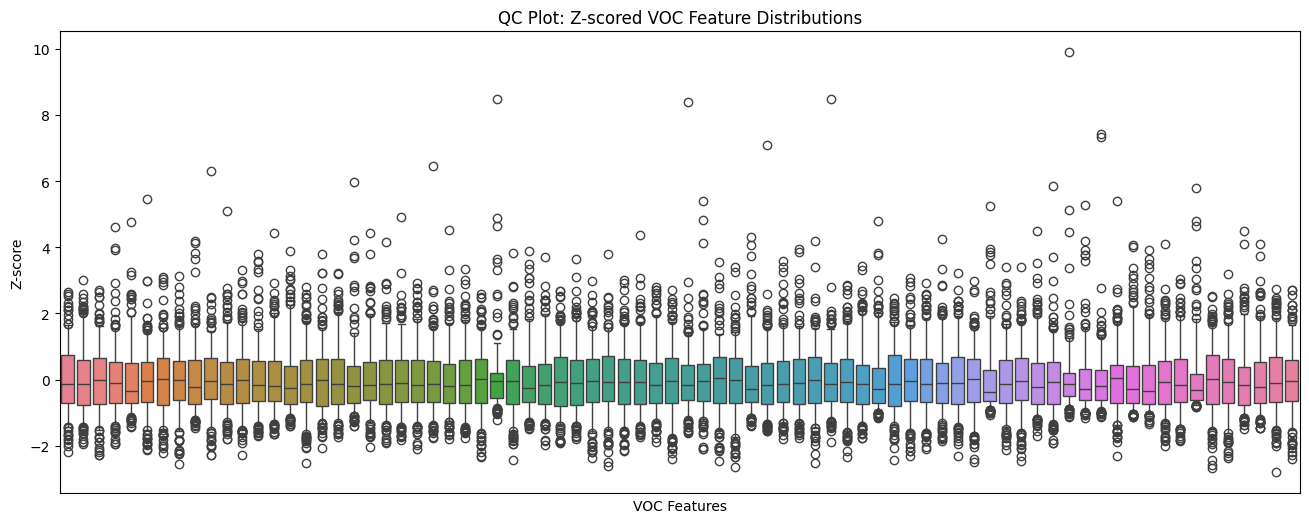

In [9]:
from sklearn.preprocessing import StandardScaler

# Extract VOC feature columns
feature_cols = df_main2_clean_filter.columns  # same 79 features

scaler = StandardScaler()
df_main3_z = df_main3.copy()
df_main3_z[feature_cols] = scaler.fit_transform(df_main3[feature_cols])

# QC
print(f"Z-scored feature means (should be ~0):{df_main3_z[feature_cols].mean()} \n")
print(f"Z-scored feature std devs (should be ~1): {df_main3_z[feature_cols].std()} \n")

# Boxplot
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_main3_z[feature_cols], whis=[5, 95])
plt.title('QC Plot: Z-scored VOC Feature Distributions')
plt.xlabel('VOC Features')
plt.ylabel('Z-score')
plt.xticks([], [])  # x-axis labels hidden for clarity bc so many features
plt.show()

When looking at the above plot...
* no one feature stands out more than another
* Most are centered around 0
* IQR mostly between +/- 1
* Outliers are both above and below which seems to make sense given variability of breath based VOCs

**QC checks out, normalization worked**

In [10]:
# switching data into 0 and 1 format
df_main3_z['TB Status'] = df_main3_z['TB Status'].map({'Negative': 0, 'Positive': 1})
df_main3_z['HIV Status'] = df_main3_z['HIV Status'].map({'Negative': 0, 'Positive': 1})
df_main3_z['HIV Status'] = df_main3_z['HIV Status'].fillna(-1)
df_main3_z['Age'] = df_main3_z['Age'].fillna(-1)
df_main3_z['BMI'] = df_main3_z['BMI'].fillna(-1)
# saving
df_main3_z.to_csv('df_main_normalized.csv', index=False)